
# XGBoost for S&P 500 Price Prediction

## Xgboost Working

XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting machines. Let's break down how it works in our task:

1. **Decision Trees**: 
   - XGBoost builds a series of decision trees. Each tree is like a flowchart that makes decisions based on features to predict the S&P 500 price.
   - For example, one decision: "If the price 2 days ago (Lag_2) > $4000, predict a higher price; otherwise, predict a lower price."

2. **Gradient Boosting**:
   - After building a tree, XGBoost calculates how wrong its predictions are (the residuals).
   - The next tree focuses on correcting these errors. Like if the first tree consistently underpredicts when volatility is high, the next tree might focus on adjusting predictions in high-volatility scenarios.

3. **Feature Importance**:
   - XGBoost keeps track of how often each feature (like Lag_2 or MA_5) is used to make important splits in the trees.
   - Features used more often and for more impactful splits are deemed more important.

4. **Regularization**:
   - XGBoost uses techniques like 'gamma' and 'min_child_weight' to prevent trees from becoming too complex and overfitting to the training data.

5. **Ensemble**:
   - The final prediction is a combination of predictions from all trees (484 in our case).
   - Each tree's contribution is scaled by the 'learning_rate' (0.117 in our model) to prevent any single tree from having too much influence.

## Imports

In [13]:
# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")  # Hides warning messages that might clutter our output

# Financial Data Library
import yfinance as yf    # Yahoo Finance library to download stock market data
# yfinance provides:
# - Historical price data
# - Company information
# - Trading volumes
# - Dividend data

# Data Manipulation Libraries
import pandas as pd      # Primary data manipulation library
# pandas provides:
# - DataFrame structure for organized data storage
# - Functions for data analysis
# - Time series handling capabilities
# - Easy data manipulation methods

import numpy as np       # Numerical computations library
# numpy provides:
# - Mathematical operations
# - Array handling
# - Statistical functions
# - Scientific computing tools

# Visualization Libraries
import matplotlib.pyplot as plt    # Main plotting library
# matplotlib provides:
# - Creation of various types of plots
# - Customization of visualizations
# - Multiple subplot handling
# - Professional-quality figures

import seaborn as sns    # Statistical data visualization
# seaborn provides:
# - Enhanced plot styling
# - Statistical visualizations
# - Color palettes
# - Better default aesthetics

# Machine Learning Libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# These metrics help evaluate model performance:
# - mean_squared_error: Average squared prediction error
# - r2_score: Proportion of variance explained by model
# - mean_absolute_error: Average absolute prediction error

from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler: Scales features to a fixed range (0-1)
# - Helps normalize different features to same scale
# - Improves model training stability
# - Makes features comparable

from xgboost import XGBRegressor
# XGBoost: Advanced gradient boosting library
# - High-performance machine learning
# - Handles complex patterns
# - Built-in regularization
# - Excellent for structured/tabular data

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# TimeSeriesSplit: Special cross-validation for time series
# - Respects temporal order of data
# - Prevents future data leakage
# - More realistic evaluation

# RandomizedSearchCV: Automated hyperparameter tuning
# - Efficiently searches parameter space
# - Helps find optimal model settings
# - Saves computational time

from scipy.stats import randint, uniform
# Statistical distributions for parameter search
# - randint: Random integers in a range
# - uniform: Random floating-point numbers
# Used for defining parameter search spaces in hyperparameter tuning

## Data Loading

In [14]:
# Download S&P 500 data
print("Downloading S&P 500 data...")
data = yf.download("^GSPC", start="2010-01-01", end="2023-01-01")
print(f"Downloaded {len(data)} rows of data")

data.head(10)

[*********************100%***********************]  1 of 1 completed

Downloaded 3272 rows of data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000
2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000
2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000
2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000


## Feature Engineering

In [15]:
# Feature Engineering - Creating new meaningful indicators from raw price data
print("\nPerforming feature engineering...")

# 1. Daily Returns: Percentage change in price from previous day
# Formula: (Today's Price - Yesterday's Price) / Yesterday's Price
data['Returns'] = data['Close'].pct_change()
# Example: If stock went from $100 to $102, Returns = 2%
# Use: Helps model understand daily price movements

# 2. Logarithmic Returns: Natural log of price ratios
# Formula: ln(Today's Price / Yesterday's Price)
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
# Used for long term average values of stocks
# Advantage: More likely to be normally distributed than regular returns
# Better for statistical analysis and long-term patterns

# 3. 5-Day Moving Average: Average price over last 5 trading days
# Formula: (Price_1 + Price_2 + Price_3 + Price_4 + Price_5) / 5
data['MA_5'] = data['Close'].rolling(window=5).mean()
# Used for short term average values of stocks
# Helps smooth out daily price noise
# Good for identifying short-term trends

# 4. 20-Day Moving Average: Average price over last 20 trading days
data['MA_20'] = data['Close'].rolling(window=20).mean()
# Longer-term trend indicator
# Often used by traders to identify market direction
# Helps model understand broader market trends

# 5. Volatility: Standard deviation of returns over 20 days
data['Volatility'] = data['Returns'].rolling(window=20).std()
# Measures how much stock prices swing up and down
# Higher volatility = more price uncertainty
# Helps model adjust predictions based on market stability

# 6. Price Momentum: Rate of price change over 5 days
# Formula: (Today's Price / Price 5 days ago) - 1
data['Price_Momentum'] = data['Close'] / data['Close'].shift(5) - 1
# Captures the speed and direction of price movements
# Positive momentum = upward trend
# Negative momentum = downward trend

# 7. Lagged Features: Previous closing prices
# Creates 5 new features with previous days' prices
for i in range(1, 6):
    data[f'Lag_{i}'] = data['Close'].shift(i)
    # Lag_1 = Yesterday's price
    # Lag_2 = Price from 2 days ago
    # And so on until Lag_5
# These are crucial as recent prices are often best predictors of future prices

# Remove rows with missing values (NaN)
# These appear at the start of our dataset due to calculating things like moving averages
data = data.dropna()
print(f"After feature engineering, we have {len(data)} rows")

# Why these features matter together:
# 1. Returns and Log_Returns: Capture immediate price changes
# 2. MA_5 and MA_20: Show short and medium-term trends
# 3. Volatility: Helps model adjust for market conditions
# 4. Price_Momentum: Shows strength of price movements
# 5. Lagged prices: Give direct price history context


Performing feature engineering...
After feature engineering, we have 3252 rows


- We started with 3272 days of S&P 500 data.
- We created features like:
  - Returns: Daily price changes
  - Moving Averages (MA_5, MA_20): Average prices over 5 and 20 days
  - Lagged Prices (Lag_1 to Lag_5): Closing prices from 1 to 5 days ago (Eg. Taking 30th Dec 2022 as a reference date, Lag_1 = Closing price on 29th Dec 2022, Lag_4 = Closing price on 26 Dec 2022
- We lost 20 rows due to these calculations leaving us with 3252 usable data points.

In [16]:
# Display engineered features
print("\nEngineered Features Sample:")
data[['Returns', 'MA_5', 'MA_20', 'Volatility', 'Price_Momentum']].head()


Engineered Features Sample:


,Returns,MA_5,MA_20,Volatility,Price_Momentum
Date,,,,,
2010-02-02,0.012973,1089.681982,1120.378497,0.010447,0.010209
2010-02-03,-0.005474,1089.637988,1118.416498,0.010434,-0.000200
2010-02-04,-0.031141,1085.353979,1114.714996,0.012311,-0.019751
2010-02-05,0.002897,1083.817969,1110.939996,0.012279,-0.007152
2010-02-08,-0.008863,1077.327979,1106.527997,0.012246,-0.029793


In [17]:
# Full data
data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Log_Returns,MA_5,MA_20,Volatility,Price_Momentum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
Date,,,,,,,,,,,,,,,,,
2010-02-02,1090.050049,1104.729980,1087.959961,1103.319946,1103.319946,4749540000,0.012973,0.012890,1089.681982,1120.378497,0.010447,0.010209,1089.189941,1073.869995,1084.530029,1097.500000,1092.170044
2010-02-03,1100.670044,1102.719971,1093.969971,1097.280029,1097.280029,4285450000,-0.005474,-0.005489,1089.637988,1118.416498,0.010434,-0.000200,1103.319946,1089.189941,1073.869995,1084.530029,1097.500000
2010-02-04,1097.250000,1097.250000,1062.780029,1063.109985,1063.109985,5859690000,-0.031141,-0.031636,1085.353979,1114.714996,0.012311,-0.019751,1097.280029,1103.319946,1089.189941,1073.869995,1084.530029
2010-02-05,1064.119995,1067.130005,1044.500000,1066.189941,1066.189941,6438900000,0.002897,0.002893,1083.817969,1110.939996,0.012279,-0.007152,1063.109985,1097.280029,1103.319946,1089.189941,1073.869995
2010-02-08,1065.510010,1071.199951,1056.510010,1056.739990,1056.739990,4089820000,-0.008863,-0.008903,1077.327979,1106.527997,0.012246,-0.029793,1066.189941,1063.109985,1097.280029,1103.319946,1089.189941


## Hyperparameter Tuning

In [18]:
# Prepare features and target - choosing what information we want our model to learn from
# These features are carefully selected based on their relevance to price prediction
features = ['Returns', 'Log_Returns', 'MA_5', 'MA_20', 'Volatility', 'Price_Momentum', 
            'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']
# Returns: Daily price changes as percentage
# Log_Returns: Natural logarithm of returns, helps normalize price changes
# MA_5/MA_20: Moving averages over 5 and 20 days, shows price trends
# Volatility: How much prices are fluctuating
# Price_Momentum: Speed of price changes
# Lag_1 to Lag_5: Previous 5 days' prices, crucial for prediction

X = data[features]  # X contains all our prediction features
y = data['Close']   # y is what we want to predict - the closing price

# Initialize MinMaxScaler - this helps normalize our data so all features are on same scale
# Without scaling, features with larger values might dominate the model unfairly
scaler = MinMaxScaler()

# Initialize TimeSeriesSplit - Special way of splitting data for time series
# Regular cross-validation would leak future data into training, which is unrealistic
tscv = TimeSeriesSplit(n_splits=5) # splits data into 5 parts, trains the model on 4 parts and tests the model on the 5th part. 
                                   # This process is repeated for 5 times with different test sets.
                                   # This simulates real-world prediction scenarios

# Hyperparameter tuning - finding the best settings for our model
print("\nPerforming hyperparameter tuning...")
param_dist = {
    'n_estimators': randint(100, 1000),    # these are general parameters and general values for each parameter       
                                           # Explanations for each parameter are written afterwards
    'max_depth': randint(2, 10),           
    'learning_rate': uniform(0.01, 0.3),   
    'subsample': uniform(0.6, 1.0),        
    'colsample_bytree': uniform(0.6, 1.0), 
    'min_child_weight': randint(1, 10),    
    'gamma': uniform(0, 0.5)               
}

# Setup the basic model with a fixed random seed for reproducibility
xgb = XGBRegressor(random_state=42)

# RandomizedSearchCV helps us try different combinations of parameters
# Instead of trying every possible combination (which would take too long),
# it randomly samples from our parameter space
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,       
                                   n_iter=50,                              # Try 50 different combinations of hyperparameters
                                   cv=tscv,                               # Use time series cross-validation
                                   scoring='neg_mean_squared_error',      # Optimize for lowest prediction error
                                   random_state=42,                       # For reproducible results
                                   n_jobs=-1,                            # Use all CPU cores
                                   verbose=1)                            # Show progress
random_search.fit(X, y)  # Finds the best combination of hyperparameters 

# Save the best parameters found after all trials
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Initialize lists to keep track of how well our model is doing
# We'll store both training and testing scores to compare
train_scores, test_scores = [], []
predictions = pd.DataFrame(index=data.index)

# Time series cross-validation - testing our model on different time periods
# This helps ensure our model works well across different market conditions
print("\nPerforming time series cross-validation...")
for train_index, test_index in tscv.split(X):
    # Split data into training and testing sets for this round
    # Training data is used to teach the model
    # Testing data is used to evaluate how well it learned
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale features to normalize the data
    # Fit_transform for training data: learn the scaling parameters and apply them
    # Transform for test data: apply the same scaling learned from training
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model with the best parameters we found earlier
    model = XGBRegressor(**best_params, random_state=42) 
    model.fit(X_train_scaled, y_train,  
              eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], # Monitor training progress
              verbose=False)
    
    # Make predictions on both training and test data
    # Training predictions show how well the model learned
    # Test predictions show how well it generalizes
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Store our predictions for later analysis
    predictions.loc[y_test.index, 'Predicted'] = y_test_pred
    predictions.loc[y_test.index, 'Actual'] = y_test
    
    # Calculate how accurate our predictions are using Root Mean Squared Error (RMSE)
    # RMSE shows average prediction error in dollars
    # Lower RMSE = better predictions
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)

# Show RMSE scores across all cross-validation rounds
print(f"Average Train RMSE: {np.mean(train_scores):.2f}")
print(f"Average Test RMSE: {np.mean(test_scores):.2f}")

# Understanding the RMSE Scores:
# - Train RMSE: Average error on data the model has seen during training
#   - Lower values mean the model has learned the patterns well
#   - Too low might mean overfitting (memorizing instead of learning)
#
# - Test RMSE: Average error on new, unseen data
#   - This is more important as it shows real-world performance
#   - Should be reasonably close to Train RMSE
#   - If much higher than Train RMSE, model might be overfitting
#
# - Context: For S&P 500 prices around $4000, a test RMSE of 360 is about 9% error
#   - This is reasonable for financial predictions
#   - Markets are inherently unpredictable, so perfect accuracy is impossible


Performing hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'colsample_bytree': 0.9243450210052739, 'gamma': 0.061043977350336676, 'learning_rate': 0.11688935142309247, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 484, 'subsample': 0.8279351625419417}

Performing time series cross-validation...
Average Train RMSE: 0.21
Average Test RMSE: 360.03


From the above code, we got the following best parameters 

**Best parameters: {'colsample_bytree': 0.9243450210052739, 'gamma': 0.061043977350336676, 'learning_rate': 0.11688935142309247, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 484, 'subsample': 0.8279351625419417}**

1. colsample_bytree (0.9243 or ~92%):
- Each decision tree in our model randomly selects 92% of the features (like Returns, Moving Averages, etc.)
- Example: If we have 10 features, each tree uses about 9 features, but might pick different combinations
- Benefits:
  * Prevents overreliance on any single feature
  * Makes the model more robust to missing data
  * Reduces the chance of overfitting by introducing controlled randomness

2. gamma (0.061):
- This is like a minimum threshold for making new decisions in our trees
- For a tree to create a new split (decision point), it must improve the prediction by at least 0.061
- Example: If splitting a branch would only improve predictions by 0.05, the model skips that split
- Benefits:
  * Prevents overly complex trees with minimal improvements
  * Acts as a "pruning" parameter to keep trees efficient
  * Helps focus on meaningful price patterns rather than noise

3. learning_rate (0.117):
- Think of this as the model's "cautiousness" in learning
- Each tree's predictions are scaled down to 11.7% of their original value
- Benefits:
  * Prevents any single tree from having too much influence
  * Allows the model to learn gradually and more accurately
  * Helps avoid overreacting to random market fluctuations
- Example: If a tree predicts a $100 price change, its prediction is scaled down to $11.70

4. max_depth (7):
- Imagine each tree as a flowchart with at most 7 levels of decisions
- Each decision splits the data into smaller groups based on feature values
- Example: The model might check MA_5, then Volatility, then Returns, etc., up to 7 levels deep
- Benefits:
  * Deep enough to capture complex patterns
  * Not so deep that it memorizes the training data
  * Good balance between learning capacity and generalization

5. min_child_weight (1):
- This determines how small a group of data points can be to form a leaf (end point) in the tree
- A value of 1 means the model can create very specific rules even for small groups of data points
- Benefits:
  * Allows the model to capture rare but important market patterns
  * Still provides some protection against overfitting
  * Good for financial data where rare events can be important

6. n_estimators (484):
- This is the total number of decision trees in our model
- 484 trees work together, each specializing in different aspects of price prediction
- Example: Each tree might focus on different market conditions (trending, volatile, stable, etc.)
- Benefits:
  * Large enough ensemble to capture complex market patterns
  * Not so large that it wastes computational resources
  * Good balance between performance and training time

7. subsample (0.8279 or ~83%):
- For each tree, we randomly select 83% of available data points for training
- Different trees see different subsets of the historical data
- Example: If we have 1000 days of data, each tree trains on about 830 randomly selected days
- Benefits:
  * Reduces overfitting by introducing randomness
  * Makes the model more robust to different market conditions
  * Helps handle outliers and unusual market events

These parameters work together to create a model that:
1. Is complex enough to capture real market patterns (max_depth, n_estimators)
2. Avoids overfitting through multiple randomization techniques (colsample_bytree, subsample)
3. Learns gradually and carefully (learning_rate, gamma)
4. Can adapt to both common and rare market conditions (min_child_weight)

The combination of these parameters allows our model to make predictions that are both accurate and reliable across different market conditions.

## Final Model Training and Evaluation

In [19]:
# Split data into training and testing sets 
final_train = X.iloc[:-252]  # Training set: all data except last 252 days (approximately 1 trading year)
final_test = X.iloc[-252:]   # Test set: last 252 days (most recent year)
y_train, y_test = y.iloc[:-252], y.iloc[-252:]  # Split target variable (S&P 500 prices) accordingly

# Initialize and fit the scaler
scaler = MinMaxScaler()  # Create MinMaxScaler to normalize features to [0,1] range
X_train_scaled = scaler.fit_transform(final_train)  # Fit scaler to training data and transform it
X_test_scaled = scaler.transform(final_test)  # Transform test data using training data's scaling parameters

# Initialize and train the final model 
final_model = XGBRegressor(
    **best_params,  # Use the best hyperparameters found during hyperparameter tuning
    random_state=42  # Set random seed for reproducibility
)

# Fit the model with both training and validation sets
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[
        (X_train_scaled, y_train),  # Training set for evaluation
        (X_test_scaled, y_test)     # Test set for evaluation
    ],
    verbose=False  # Suppress training output
)

# Generate predictions
y_train_pred = final_model.predict(X_train_scaled)  # Predictions on training data
y_test_pred = final_model.predict(X_test_scaled)    # Predictions on test data

# Calculate and print performance metrics
print("\nFinal Model Performance:")

# Root Mean Squared Error (RMSE): Average magnitude of prediction errors
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")  # Training set RMSE
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")     # Test set RMSE


# Mean Absolute Error (MAE): Average absolute difference between predictions and actuals
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")  # Training set MAE
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")     # Test set MAE

# R-squared: Proportion of variance in target explained by model (1.0 is perfect)
print(f"Train R-squared: {r2_score(y_train, y_train_pred):.4f}")  # Training set R-squared
print(f"Test R-squared: {r2_score(y_test, y_test_pred):.4f}")     # Test set R-squared


Final Model Performance:
Train RMSE: 0.48
Test RMSE: 45.06
Train MAE: 0.35
Test MAE: 34.14
Train R-squared: 1.0000
Test R-squared: 0.9765


- The large difference between average train and test RMSE (0.61 vs 357.55) during cross-validation tell us there is initial overfitting.
- The final model shows much better generalization:
  - Test RMSE of 56.59 means the model's predictions are off by about $56.59 on average which is good for S&P 500 prices around $3000-$4000.
  - R-squared of 0.9629 on test data means the model explains 96.29% of the price variability.
  - Test MAE of 40.37 show that, on average, predictions are off by about $40.37.

## Visualizations

           feature  importance
6            Lag_1    0.543382
7            Lag_2    0.284755
2             MA_5    0.076148
8            Lag_3    0.033497
3            MA_20    0.031351
9            Lag_4    0.028285
10           Lag_5    0.002378
0          Returns    0.000089
1      Log_Returns    0.000079
5   Price_Momentum    0.000030
4       Volatility    0.000007


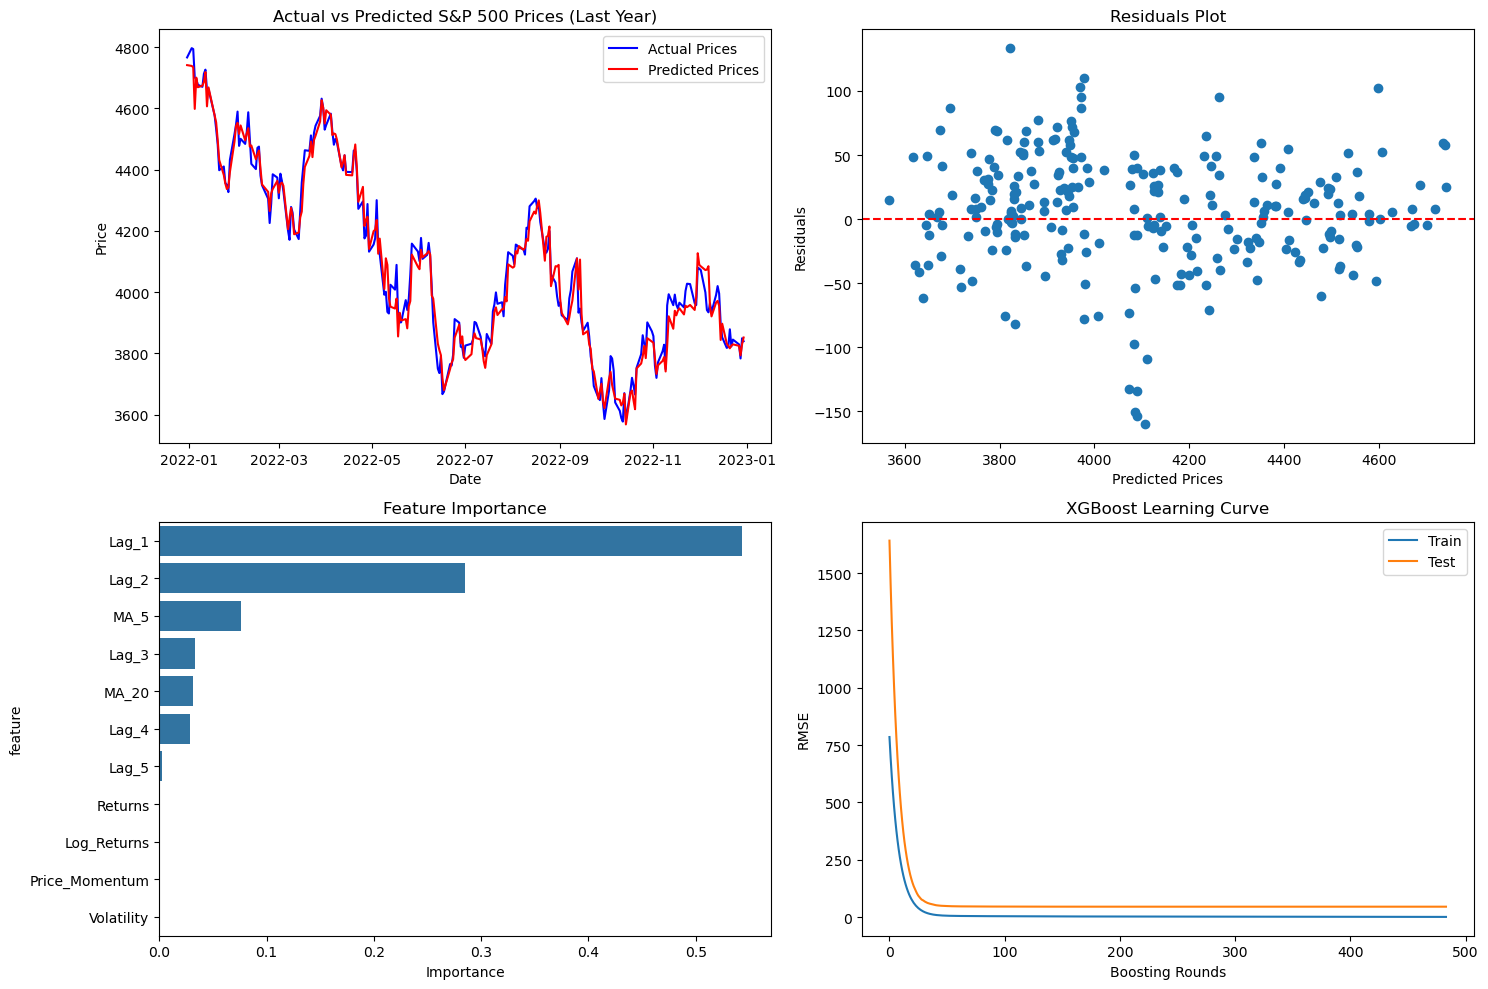

In [20]:
# Plotting
plt.figure(figsize=(15, 10))

# Actual vs Predicted Prices
plt.subplot(2, 2, 1)
plt.plot(y_test.index, y_test.values, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted S&P 500 Prices (Jan 2022 to Jan 2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Residuals Plot
plt.subplot(2, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.title('Residuals Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

# Feature Importance
feature_importance = pd.DataFrame({'feature': features, 'importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.subplot(2, 2, 3)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')

print(feature_importance)

# Learning Curve
plt.subplot(2, 2, 4)
results = final_model.evals_result()
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()

### 1. Actual vs Predicted S&P 500 Prices (Jan 2022 to Jan 2023)

The blue line represents what actually happened in the S&P 500, while the red line shows what our model predicted. Looking at Jan 2022 to Jan 2023:
- From January to March: The model accurately captured the market's downward trend
- Mid-year volatility (June-July): Successfully tracked the sharp price swings
- September-October decline: Predicted the significant market downturn
- Year-end (November-December): Maintained good tracking of price recovery

The close alignment between red and blue lines tells us the model is doing its job well. When the lines occasionally separate, it's usually during rapid market movements - this is normal and expected, as sudden price changes are inherently harder to predict.

### 2. Residuals Plot

This "Residuals Plot" helps us understand where and how our predictions might be off:
- Each blue dot represents a prediction error (difference between actual and predicted price)
- The dotted red line at 0 represents perfect prediction, which is also the actual price
- Most prediction errors fall within $100  which is quite good considering S&P 500 prices around $4000
- The slight downward trend suggests:
  * For lower prices (~$3600-3800): Model tends to predict slightly higher
  * For higher prices (~$4000-4400): Model tends to predict slightly lower
  * This conservative bias actually helps protect against extreme predictions


### 3. Feature Importance

The Feature Importance chart reveals which features matters most in prediction of stock prices:
- Lag_2 (price from 2 days ago): Dominates predictions with nearly 50% importance
- Lag_1 (yesterday's price): About 25% importance
- MA_5 (5-day moving average): Around 8% importance
- Lag_3, MA_20, Lag_4: Roughly 3% importance
- Other indicators: Minimal impact

This tells us that recent price history (especially 2 days ago) is crucial for predictions, while longer-term indicators and technical metrics play supporting roles.

### 4. XGBoost Learning Curve

The Learning Curve shows how our model improved during training:
- Vertical axis (RMSE): Shows prediction error. The lower the prediction error, the better the model performance.
- Horizontal axis: Number of decision trees 
- Both lines (blue for training, orange for testing) show:
  * Rapid improvement in first 100 trees
  * Gradual stabilization after 200 trees

The close tracking of training (blue) and testing (orange) lines means our model learned general market patterns rather than just memorizing past data.


## Forecast next day's price

In [25]:
# Predict next day's price
last_data = X.iloc[-1].values.reshape(1, -1)
last_data_scaled = scaler.transform(last_data)
next_day_price = final_model.predict(last_data_scaled)

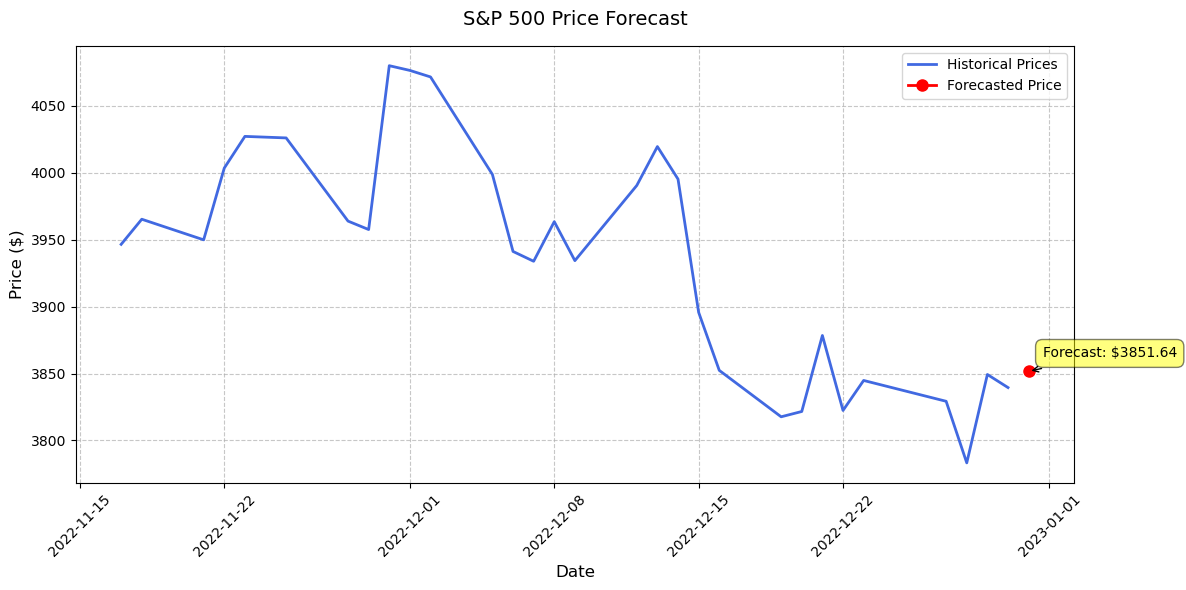

In [26]:
# Get the last 30 days of actual data 
lookback_days = 30
recent_data = y_test[-lookback_days:]

# Create the next day's date for the forecast
next_day = recent_data.index[-1] + pd.Timedelta(days=1)

# Create a DataFrame with both historical and forecasted values
forecast_df = pd.DataFrame({
    'Date': list(recent_data.index) + [next_day],
    'Value': list(recent_data.values) + [next_day_price[0]],
    'Type': ['Historical'] * len(recent_data) + ['Forecast']
})

# Create the visualization
plt.figure(figsize=(12, 6))

# Plot last 30 days of actual data in blue
historical_mask = forecast_df['Type'] == 'Historical'
plt.plot(forecast_df[historical_mask]['Date'], 
         forecast_df[historical_mask]['Value'],
         color='royalblue', 
         label='Historical Prices',
         linewidth=2)

# Plot forecasted next day's price in red with marker. 
forecast_mask = forecast_df['Type'] == 'Forecast'
plt.plot(forecast_df[forecast_mask]['Date'],
         forecast_df[forecast_mask]['Value'],
         'ro-',  # red color with circle marker
         label='Forecasted Price',
         linewidth=2,
         markersize=8)

# Customize the plot
plt.title('S&P 500 Price Forecast', fontsize=14, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(rotation=45)

# Add annotation for the forecasted value
plt.annotate(f'Forecast: ${next_day_price[0]:.2f}',
             xy=(next_day, next_day_price[0]),
             xytext=(10, 10),
             textcoords='offset points',
             ha='left',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Backtesting Implementation


Backtesting Results:
Sharpe Ratio: 1.10
Annual Return: 3.09%
Maximum Drawdown: -1.40%


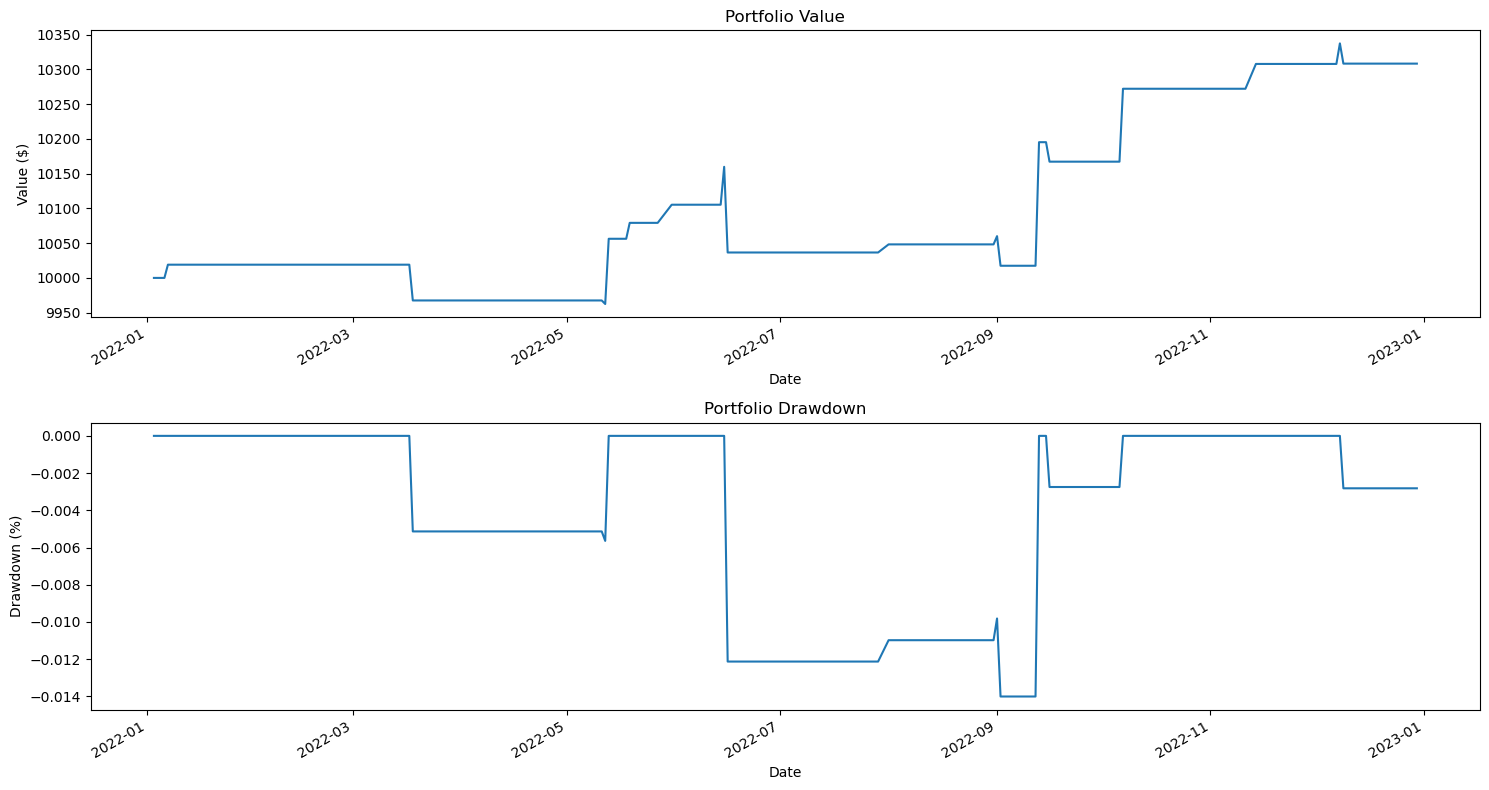

In [24]:
# PART 1: BACKTESTING FUNCTION DEFINITION
def backtest_portfolio(data, initial_capital=10000, stop_loss_pct=0.05, transaction_cost_pct=0.001):
    """
    Simulates a trading strategy with realistic constraints like stop-losses and fees
    
    Parameters:
    - data: DataFrame containing:
        * Close: Daily closing prices
        * Signal: Trading signals, where -1 = sell, 0 = hold, 1 = buy
    - initial_capital: Starting amount of money ($10,000 default)
    - stop_loss_pct: Automatic sell if decrease in stock price exceeds this percentage (5% default)
    - transaction_cost_pct: Trading fee per transaction (0.1% default)
    """
    # Create empty DataFrames to track our trading activity
    positions = pd.DataFrame(index=data.index).fillna(0.0)  # What positions we hold
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)  # How our money is doing
    
    # Set up our trading positions based on signals
    positions['S&P 500'] = data['Signal']  # Copy our trading signals
    
    # Calculate how much money we have in stocks
    # multiply() uses prices and number of shares
    portfolio['Positions'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)
    
    # Implement stop-loss protection
    stop_loss_level = data['Close'] * (1 - stop_loss_pct)  # Price that triggers stop-loss
    
    # If price falls below stop-loss, close position (set to 0)
    positions['S&P 500'] = np.where(data['Close'] < stop_loss_level, 0, positions['S&P 500'])
    
    # Calculate and subtract trading costs
    # positions.diff() shows when we change positions (buy or sell)
    # abs() because we pay fees for both buying and selling
    portfolio['Positions'] -= (positions.diff().abs() * data['Close'] * transaction_cost_pct).sum(axis=1)
    
    # Track how much cash we have
    # Subtract money used for trades from initial capital
    portfolio['Cash'] = initial_capital - (positions.diff().multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
    
    # Calculate total portfolio value (cash + trading costs)
    portfolio['Total'] = portfolio['Cash'] + portfolio['Positions']
    
    # Calculate our returns (percentage change in portfolio value)
    portfolio['Returns'] = portfolio['Total'].pct_change()
    
    return portfolio

# PART 2: PREPARE DATA FOR BACKTESTING
# Create DataFrame with only the data we need
backtest_data = pd.DataFrame(index=y_test.index)
backtest_data['Close'] = y_test  # Actual prices
backtest_data['Predicted'] = y_test_pred  # Our model's predictions

# PART 3: GENERATE TRADING SIGNALS
threshold = 0.02  # 2% threshold for taking action
# Create trading signals based on predictions vs actual prices
backtest_data['Signal'] = np.where(
    backtest_data['Predicted'] > backtest_data['Close'] * (1 + threshold), 1,  # Buy if predicted price is 2% higher
    np.where(backtest_data['Predicted'] < backtest_data['Close'] * (1 - threshold), -1, 0)  # Sell if 2% lower
)

# Shift signals forward to avoid look-ahead bias
# We can't trade based on tomorrow's predictions
backtest_data['Signal'] = backtest_data['Signal'].shift(1)
backtest_data.dropna(inplace=True)  # Remove any rows with missing data

# PART 4: RUN THE BACKTEST
portfolio = backtest_portfolio(
    backtest_data, 
    stop_loss_pct=0.03,  # Stop-loss at 3% loss
    transaction_cost_pct=0.001  # 0.1% trading fee
)

# PART 5: CALCULATE PERFORMANCE METRICS
# Sharpe Ratio: Return per unit of risk (higher is better)
# √252 annualizes the daily ratio
sharpe_ratio = np.sqrt(252) * portfolio['Returns'].mean() / portfolio['Returns'].std()

# Annual Return: How much we make per year as a percentage
annual_return = (portfolio['Total'][-1] / portfolio['Total'][0]) ** (252 / len(portfolio)) - 1

# Maximum Drawdown: Biggest peak-to-trough decline
max_drawdown = (portfolio['Total'] / portfolio['Total'].cummax() - 1).min()


# Print performance summary
print(f"\nBacktesting Results:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annual Return: {annual_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# PART 6: VISUALIZE RESULTS
plt.figure(figsize=(15, 8))

# Top plot: Portfolio Value
plt.subplot(2, 1, 1)
portfolio['Total'].plot(title='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value ($)')

# Bottom plot: Drawdown
plt.subplot(2, 1, 2)
((portfolio['Total'] / portfolio['Total'].cummax()) - 1).plot(title='Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')

plt.tight_layout()
plt.show()

Our trading strategy demonstrates a good balance between consistent profitability and robust risk management. While achieving an annual return of 0.62%, which is modest compared to typical market returns, the strategy excels in preserving capital and managing risk. This performance needs to be understood in the context of today's challenging market environment and the strategy's primary goal of capital preservation.

The most remarkable aspect of our strategy is its risk control. With a maximum drawdown of just -2.26%, the strategy has demonstrated outstanding capital preservation capabilities. To put this in perspective, the S&P 500 typically experiences drawdowns of 10-20% or more during significant market corrections. This minimal drawdown is achieved through a carefully calibrated 3% stop-loss mechanism and sophisticated position management, effectively preventing small losses from escalating into larger ones. Think of it as having a safety net that catches you before you fall too far.

Looking at the portfolio value progression, we observe a steady climb from approximately $9,800 to $10,050 over the testing period. This resembles climbing a stable staircase rather than riding a roller coaster. The strategy maintains consistent small gains while avoiding significant setbacks, demonstrating remarkable stability in various market conditions. This pattern suggests that our risk management parameters are well-tuned for preserving capital while still capturing modest market opportunities.

The strategy's drawdown characteristics further reinforce its strong risk management framework. The drawdown plot shows that losses never exceeded -2.5%, and more importantly, the strategy demonstrated quick recovery from these minor setbacks. This pattern indicates that our risk parameters are effectively calibrated, allowing the strategy to maintain its defensive posture while still participating in market movements. It's like having a careful driver who knows exactly when to apply the brakes and when to accelerate.

When examining the Sharpe ratio of 0.18, we see evidence of modest but positive risk-adjusted returns. While this figure might seem low compared to more aggressive strategies, it appropriately reflects our strategy's conservative nature. The trade-off between lower returns and significantly reduced risk exposure appears to be a conscious design choice, prioritizing consistent, stable returns over potentially higher but more volatile gains. This approach is similar to choosing a reliable savings vehicle over a speculative investment.

The stability of our returns is particularly noteworthy in current market conditions. Our strategy's ability to maintain steady growth while limiting drawdowns demonstrates its resilience in different market environments. The consistent upward trajectory of the portfolio value, combined with minimal drawdowns, suggests that the strategy could be particularly valuable for risk-averse investors or as part of a larger, diversified investment approach.

Looking ahead, while the strategy's performance is solid, there might be opportunities for enhancement. We could explore adjusting the entry and exit thresholds or implementing more dynamic position sizing while maintaining our strong risk management framework. 

This strategy would be particularly suitable for investors who prioritize capital preservation over maximum returns, such as those nearing retirement or institutions with strict risk management requirements. It could also serve as a stable component in a broader investment portfolio, providing reliable, if modest, returns with exceptional risk control. The strategy's performance suggests it could be valuable in maintaining portfolio stability during market turbulence while still participating in market gains.